# Chapter 11 - I2VIS

This is an implementation of a 2D viscous flow code. The energy equation (for temperature) is solved at the cell centers (unlike the example in the chapter 10 notebook, which is solved at the basic nodes.

In [1]:
# Import necessary packages
using SparseArrays
using LinearAlgebra
using IterativeSolvers
using WriteVTK
using Printf
using Pardiso

include("Grid.jl")
include("Markers.jl")
include("Stokes.jl")

using PyPlot

In [2]:
# Define a function to form the energy equation left hand side and right hand side
function assemble_energy_equation_center(grid::CartesianGrid,rho::Matrix,Cp::Matrix,kThermal::Matrix,H::Matrix,Tlast::Matrix,dt)
    bcleft  = -1   # -1 = insulating, 1 = constant temp
    bcright = -1   #
    bctop   =  1
    bcbottom  = 1
    bcval = [0.0,0.0,1000.0,1000.0] # left,right,top,bottom
    
    N = grid.nx*grid.ny
    row = zeros(Int64,5*N);
    col = zeros(Int64,5*N);
    val = zeros(Float64, 5*N);
    R = zeros(Float64,N,1);
    k = 1;
    #        j-1   j     j   j+1   j+1
    #   i-1   |----kC----|----vy----|
    #         |          |          |
    #   i     kA    T   kB    T     |
    #         |          |          |
    #   i     |----kD--(i,j)--vy----|
    #         |          |          |
    #   i+1   vx    c    vx   c     vx
    #         |          |          |
    #   i+1   |----vy----|----vy----|
    
    for j in 1:grid.nx
        dxc = j>1 ? grid.x[j] - grid.x[j-1] : grid.x[j+1] - grid.x[j]
        dxp = grid.xc[j+1] - grid.xc[j]
        dxm = j>1 ? grid.xc[j]-grid.xc[j-1] : grid.xc[j+1] - grid.xc[j]
        for i in 1:grid.ny
            dyc = i>1 ? grid.y[i] - grid.y[i-1] : grid.y[i+1] - grid.y[i]
            dyp = grid.yc[i+1] - grid.yc[i]
            dym = i>1 ? grid.yc[i]-grid.yc[i-1] : grid.yc[i+1] - grid.yc[i]
            
            this_row = node_index(i,j,grid.ny);
            if i==1 # ghost nodes along top.
                row[k] = this_row
                col[k] = this_row
                val[k] = 1.0/2.0
                k+=1
                
                row[k] = this_row
                col[k] = node_index(i+1,j,grid.ny)
                val[k] = bctop/2.0
                k+=1
                
                R[this_row] = bcval[3]
            elseif j==1 # ghost nodes along left side.
                row[k] = this_row
                col[k] = this_row
                val[k] = 1.0/2.0
                k+=1
                
                row[k] = this_row
                col[k] = node_index(i,j+1,grid.ny)
                val[k] = bcleft/2.0
                k+=1
                
                R[this_row] = bcval[1]
            else            
                # kA, kB, kC, kD
                kA = 0.5*(kThermal[i-1,j-1] + kThermal[i,j-1])
                kB = 0.5*(kThermal[i,j]     + kThermal[i-1,j])
                kC = 0.5*(kThermal[i-1,j-1] + kThermal[i-1,j])
                kD = 0.5*(kThermal[i,j-1]   + kThermal[i,j])
                rho_c = 0.25*(rho[i-1,j-1] + rho[i,j-1] + rho[i-1,j] + rho[i,j])
                Cp_c = 0.25*(Cp[i-1,j-1] + Cp[i,j-1] + Cp[i-1,j] + Cp[i,j])

                # diagonal entry
                row[k] = this_row;
                col[k] = this_row;
                val[k] = (rho_c*Cp_c)/dt + kB/dxp/dxc + kA/dxm/dxc + kD/dyp/dyc + kC/dyp/dyc;
                k+=1
                # right
                row[k] = this_row;
                #col[k] = j==grid.nx ? node_index(i,2,grid.ny) : node_index(i,j+1,grid.ny);
                col[k] = j==grid.nx ? node_index(i,j,grid.ny) : node_index(i,j+1,grid.ny);
                val[k] = j==grid.nx ? bcright*kB/dxp/dxc : -kB/dxp/dxc;
                k+=1
                # left
                row[k] = this_row;
                col[k] = node_index(i,j-1,grid.ny);
                val[k] = -kA/dxm/dxc;
                k+=1
                # down (+y)
                row[k] = this_row;
                col[k] = i==grid.ny ? node_index(i,j,grid.ny) : node_index(i+1,j,grid.ny);
                val[k] = i==grid.ny ? bcbottom*kD/dyp/dyc : -kD/dyp/dyc;
                k+=1
                # up (-y)
                row[k] = this_row;
                col[k] = node_index(i-1,j,grid.ny);
                val[k] = -kC/dyp/dyc;
                k+=1
                
                R[this_row] = Tlast[i,j]*rho_c*Cp_c/dt;
                if j==grid.nx
                    R[this_row] += 2*bcval[2]*bcright*kB/dxp/dxc
                end
                if i==grid.ny
                    R[this_row] += 2*bcval[4]*bcbottom*kD/dyp/dyc
                end
            end
        end
    end
    row = @views row[1:k-1]
    col = @views col[1:k-1]
    val = @views val[1:k-1]
    L = sparse(row,col,val)
    return L,R
end

function ghost_temperature(grid::CartesianGrid,T::Matrix{Float64})
    # Define a new grid that is (ny+1)x(nx+1) and insert the ghost temperature values.
    bcleft  = -1   # -1 = insulating, 1 = constant temp
    bcright = -1   #
    bctop   =  1
    bcbottom  = 1
    bcval = [0.0,0.0,1000.0,1000.0] # left,right,top,bottom
    Tpad = Array{Float64,2}(undef,grid.ny+1,grid.nx+1)
    Tpad[1:grid.ny,1:grid.nx] = T[1:grid.ny,1:grid.nx]
    # right side first
    for i in 1:grid.ny
        if bcright == 1
             Tpad[i,grid.nx+1] = 2.0*bcval[2]-Tpad[i,grid.nx]
        elseif bcright == -1
            Tpad[i,grid.nx+1] = Tpad[i,grid.nx]
        end
    end
    # bottom
    for j in 1:grid.nx+1
        if bcbottom == 1
            Tpad[grid.ny+1,j] = 2.0*bcval[4]-Tpad[grid.ny,j]
        elseif bcbottom == -1
            Tpad[grid.ny+1,j] = Tpad[grid.ny,j]
        end
    end
    return Tpad
end

function subgrid_temperature_relaxation!(markers::Markers,grid::CartesianGrid,Tlast::Matrix,Cp,kThermal,dt::Float64)
        dsubgrid = 1.0; # subgrid temperature diffusivity
        dT_subgrid_m = Array{Float64,2}(undef,1,markers.nmark)
        # compuate the nodal temperature on the markers.    
        cell_center_to_markers!(markers,grid,Tlast,dT_subgrid_m)
    
        # compute the subgrid temperature changes on the markers
        rho = markers.scalarFields["rho"]
        T = markers.scalarFields["T"]
        Threads.@threads for i in 1:markers.nmark
            dx2 = (grid.x[markers.cell[1,i]+1] - grid.x[markers.cell[1,i]])^2
            dy2 = (grid.y[markers.cell[2,i]+1] - grid.y[markers.cell[2,i]])^2
            tdiff = markers.scalars[rho,i]*Cp/kThermal / (2/dx2 + 2/dy2)
            dT_subgrid_m[i] = (dT_subgrid_m[i]-markers.scalars[T,i])*( 1.0 - exp(-dsubgrid*dt/tdiff) )
        end
        # interpolate subgrid temperature changes back onto basic nodes.
        markers.scalars[T,1:markers.nmark] += dT_subgrid_m[1,:]
    
        return marker_to_cell_center(markers,grid,dT_subgrid_m)[1]
end

function initial_conditions!(markers::Markers)
    rho = markers.scalarFields["rho"]
    eta = markers.scalarFields["eta"]
    T = markers.scalarFields["T"]
    for i in 1:markers.nmark
        mx = markers.x[1,i]
        my = markers.x[2,i]
        mr = ((mx-2.5e5)^2 + (my-2.5e5)^2)^0.5
        # my initial misunderstanding of the problem setup:
        # markers.rho[i] = mx >= 200e3 && mx <= 300e3 ? 3200. : 3300.
        markers.scalars[rho,i] = mr < 1.0e5 ? 3200. : 3300.
        markers.scalars[eta,i] = mr < 1.0e5 ? 1e20 : 1e21 
        markers.scalars[T,i] = mr < 1.0e5 ? 1300. : 1000.
    end
end

function visualization(grid::CartesianGrid,rho::Matrix,eta::Matrix,vn::Array{Float64},pressure::Matrix,temperature::Matrix,time ; filename="test.vts")
    # write the visualization output from the regular grid as a .vts file.
    vtk_grid(filename, grid.x, grid.y) do vtk
        vtk["rho"] = transpose(rho)
        vtk["viscosity"] = transpose(eta)
        # add a fake third dimension to the velocity vectors
        v3 = Array{Float64,3}(undef,3,grid.nx,grid.ny)
        v3[1:2,:,:] = vn
        v3[3,:,:] .= 0.0
        vtk["Velocity"] = v3
        vtk["Temperature"] = transpose(temperature)
        vtk["pressure"] = transpose(pressure[2:end,2:end])
        vtk["TIME"] = time
    end
end

function visualization(markers::Markers,time; filename="markers.vtp")  
    p3 = Array{Float64,2}(undef,3,markers.nmark)
    p3[1:2,:] = markers.x[1:2,1:markers.nmark]
    p3[3,:] .= 0.0
      
    polys = [MeshCell(PolyData.Polys(),i:i) for i in 1:markers.nmark]
    vtk_grid(filename,p3,polys) do vtk    
        for key in keys(markers.scalarFields)
            vtk[key] = markers.scalars[markers.scalarFields[key],1:markers.nmark]
        end
       vtk["TIME"] = time
    end
end

visualization (generic function with 2 methods)

# i2vis procedure

0. Set up the Eulerian grid and Lagrangian markers. Distribute the markers within the domain and assign initial conditions.
1. Compute density and viscosity at the basic nodes. Compute cell center viscosity via averaging.
2. Assemble and solve the Stokes equations.
3. Compute the maximum timestep from the velocity field and CFL number.
3. Transfer temperature from markers to basic nodes.
4. Compute the new temperature solution.
5. If the maximum temperature change exceeds a specified value, reduce the timstep and repeat step 4.
6. Compute the subgrid temperature changes and update the temperature on the markers.
7. Move the markers using 2nd order Runge-Kutta

In [7]:
function run(nstep::Int64)
nx = 51
ny = 51
W = 5e5
H = 5e5
gx = 0.0
gy = 10.0

bc = BoundaryConditions(0,0,0,0) # currently does nothing but is required argument to stokes solver.

markx = 5
marky = 5
seconds_in_year = 3.15e7
plot_interval = 1e5*seconds_in_year # plot interval in seconds
end_time = 3e7*seconds_in_year
dtmax = plot_interval
grid = CartesianGrid(W,H,nx,ny)
println("Creating Markers...")
@time markers = Markers(grid,["T","rho","eta"],["material"] ; nmx=markx,nmy=marky,random=false)
println("Initial condition...")
@time initial_conditions!(markers)

# define arrays for k, rho, cp, H at the basic nodes. Fill them with constant values for now.
kThermal = 3.0 .*ones(grid.ny,grid.nx);
Cp = 1250. .* ones(grid.ny,grid.nx);
H = zeros(grid.ny,grid.nx);
# fill!(rho,3200.);
# fill!(kThermal,3.0);
# fill!(Cp,1000.);

time = 0.0
iout=0
last_plot = 0.0

    
local rho
local eta_s
local T
local dt
local dTmax
local dTemp
local Tnew
local Tlast

output_dir = "ch11_subgrid"
for itime in 1:nstep
    # Get density and viscosity from the markers.
    rho_new,eta_s_new = marker_to_basic_node(markers,grid,["rho","eta"]);
    
    if time > 0.0
        nanind = findall(isnan.(rho_new))
        rho_new[nanind] = rho[nanind]
        eta_s_new[nanind] = eta_s[nanind]     
    end
    
    rho   = copy(rho_new)
    eta_s = copy(eta_s_new) 
    
    eta_n = viscosity_to_cell_centers(grid,eta_s_new)

    # assemble and solve the stokes equations
    L,R = form_stokes(grid,eta_s_new,eta_n,rho_new,bc,gx,gy)
    solution = L\R
    vx,vy,P = unpack(solution,grid;ghost=true)
    vxc,vyc = velocity_to_centers(grid,vx,vy)
    dt = compute_timestep(grid,vxc,vyc;dtmax=dtmax)
    
    # get temperature at cell centers
    Tlast, = marker_to_cell_center(markers,grid,["T",])
    Tlast = ghost_temperature(grid,Tlast);
    if time > 0.0
        nanind = findall(isnan.(Tlast))
        Tlast[nanind] = T[nanind]
    end
    
    dTmax = Inf
    while dTmax >= 20.0 # limit maximum temperature change
        # assemble and solve the energy equation
        println("Trying with timestep ",dt)
        L,R = assemble_energy_equation_center(grid,rho,Cp,kThermal,H,Tlast,dt);
        Tnew = L\R;
        Tnew = reshape(Tnew,grid.ny,grid.nx);
        Tnew = ghost_temperature(grid,Tnew);

        T = copy(Tnew)

        dTemp = Tnew-Tlast
        # compute the maximum temperature change
        dTmax = maximum(abs.(dTemp[2:end-1,2:end-1]))
        println("dTmax=",dTmax," dt=",dt)
        dt = min(dt,dTmax < 20.0 ? dt : dt/2)
    end
    
    dT_subgrid_node = subgrid_temperature_relaxation!(markers,grid,Tlast,Cp[1,1],kThermal[1,1],dt)
    dT_remaining = dTemp - dT_subgrid_node
#     dT_remaining = dTemp
    cell_center_change_to_markers!(markers,grid,dT_remaining,"T")
    
    if time == 0.0 || time - last_plot >= plot_interval
        last_plot = time 
        name = @sprintf("%s/viz.%04d.vtr",output_dir,iout)
        vn = velocity_to_basic_nodes(grid,vxc,vyc)

        visualization(grid,rho,eta_s,vn,P,Tnew[1:end-1,1:end-1],time/seconds_in_year;filename=name)
        name = @sprintf("%s/markers.%04d.vtp",output_dir,iout)
        visualization(markers,time/seconds_in_year;filename=name)
        iout += 1
            
            
#         figure()
#         plot(grid.xc,Tnew[5,:])
#         show()
    end
    
    move_markers_rk2!(markers,grid,vxc,vyc,dt)
    time += dt
    println("Finished Step ",itime," time=",time/seconds_in_year/1e6," Myr")
end
end
@time run(500)

Creating Markers...
  0.001012 seconds (19 allocations: 3.598 MiB)
Initial condition...
  0.001738 seconds
Trying with timestep 1.6612535796046726e12
dTmax=3.2287984419513123 dt=1.6612535796046726e12
Finished Step 1 time=0.052738208876338816 Myr
Trying with timestep 1.6620068073216125e12
dTmax=3.239606918340087 dt=1.6620068073216125e12
Finished Step 2 time=0.10550032974369158 Myr
Trying with timestep 1.661642198605562e12
dTmax=3.1881044193169146 dt=1.661642198605562e12
Finished Step 3 time=0.15825087573116978 Myr
Trying with timestep 1.663738612836563e12
dTmax=3.045679766586545 dt=1.663738612836563e12
Finished Step 4 time=0.2110679745513781 Myr
Trying with timestep 1.6625397205765522e12
dTmax=2.8804049684588335 dt=1.6625397205765522e12
Finished Step 5 time=0.2638470132998401 Myr
Trying with timestep 1.6604951295338875e12
dTmax=2.844652477554064 dt=1.6604951295338875e12
Finished Step 6 time=0.31656114439615396 Myr
Trying with timestep 1.661749114748342e12
dTmax=2.756053705023078 dt=1.66

Trying with timestep 3.15e12
dTmax=10.591416735194798 dt=3.15e12
Finished Step 79 time=5.837605878963358 Myr
Trying with timestep 3.15e12
dTmax=10.446621833161998 dt=3.15e12
Finished Step 80 time=5.937605878963358 Myr
Trying with timestep 3.15e12
dTmax=10.430634940873688 dt=3.15e12
Finished Step 81 time=6.037605878963358 Myr
Trying with timestep 3.15e12
dTmax=10.510430294405069 dt=3.15e12
Finished Step 82 time=6.137605878963358 Myr
Trying with timestep 3.15e12
dTmax=9.983461858623741 dt=3.15e12
Finished Step 83 time=6.2376058789633575 Myr
Trying with timestep 3.15e12
dTmax=9.833433646740332 dt=3.15e12
Finished Step 84 time=6.337605878963358 Myr
Trying with timestep 3.15e12
dTmax=9.671879072238198 dt=3.15e12
Finished Step 85 time=6.437605878963358 Myr
Trying with timestep 3.15e12
dTmax=9.531220021460513 dt=3.15e12
Finished Step 86 time=6.537605878963358 Myr
Trying with timestep 3.15e12
dTmax=9.377699490139094 dt=3.15e12
Finished Step 87 time=6.637605878963358 Myr
Trying with timestep 3.

Finished Step 172 time=15.137605878963356 Myr
Trying with timestep 3.15e12
dTmax=2.815075875925686 dt=3.15e12
Finished Step 173 time=15.237605878963357 Myr
Trying with timestep 3.15e12
dTmax=2.7885354937441207 dt=3.15e12
Finished Step 174 time=15.337605878963357 Myr
Trying with timestep 3.15e12
dTmax=2.762309145180552 dt=3.15e12
Finished Step 175 time=15.437605878963357 Myr
Trying with timestep 3.15e12
dTmax=2.736565767419961 dt=3.15e12
Finished Step 176 time=15.537605878963356 Myr
Trying with timestep 3.15e12
dTmax=2.7112389122603417 dt=3.15e12
Finished Step 177 time=15.637605878963356 Myr
Trying with timestep 3.15e12
dTmax=2.6863197091183793 dt=3.15e12
Finished Step 178 time=15.737605878963357 Myr
Trying with timestep 3.15e12
dTmax=2.6618098705146167 dt=3.15e12
Finished Step 179 time=15.837605878963357 Myr
Trying with timestep 3.15e12
dTmax=2.6377879760862015 dt=3.15e12
Finished Step 180 time=15.937605878963357 Myr
Trying with timestep 3.15e12
dTmax=2.6142939164028576 dt=3.15e12
Fini

Finished Step 265 time=24.43760587896336 Myr
Trying with timestep 3.15e12
dTmax=1.481003766798949 dt=3.15e12
Finished Step 266 time=24.537605878963358 Myr
Trying with timestep 3.15e12
dTmax=1.4724571407659823 dt=3.15e12
Finished Step 267 time=24.63760587896336 Myr
Trying with timestep 3.15e12
dTmax=1.4641583966802045 dt=3.15e12
Finished Step 268 time=24.737605878963357 Myr
Trying with timestep 3.15e12
dTmax=1.4560647350310774 dt=3.15e12
Finished Step 269 time=24.83760587896336 Myr
Trying with timestep 3.15e12
dTmax=1.448126927039766 dt=3.15e12
Finished Step 270 time=24.93760587896336 Myr
Trying with timestep 3.15e12
dTmax=1.4402855743412601 dt=3.15e12
Finished Step 271 time=25.037605878963358 Myr
Trying with timestep 3.15e12
dTmax=1.4325969015417286 dt=3.15e12
Finished Step 272 time=25.13760587896336 Myr
Trying with timestep 3.15e12
dTmax=1.4249456063819252 dt=3.15e12
Finished Step 273 time=25.237605878963357 Myr
Trying with timestep 3.15e12
dTmax=1.4173360390479957 dt=3.15e12
Finished

Finished Step 358 time=33.73760587896336 Myr
Trying with timestep 3.15e12
dTmax=0.9883425909451944 dt=3.15e12
Finished Step 359 time=33.83760587896336 Myr
Trying with timestep 3.15e12
dTmax=0.9843440310035021 dt=3.15e12
Finished Step 360 time=33.93760587896336 Myr
Trying with timestep 3.15e12
dTmax=0.9802468210662028 dt=3.15e12
Finished Step 361 time=34.03760587896336 Myr
Trying with timestep 3.15e12
dTmax=0.9760400797058537 dt=3.15e12
Finished Step 362 time=34.137605878963356 Myr
Trying with timestep 3.15e12
dTmax=0.9719155415091336 dt=3.15e12
Finished Step 363 time=34.23760587896336 Myr
Trying with timestep 3.15e12
dTmax=0.9677215367853478 dt=3.15e12
Finished Step 364 time=34.33760587896336 Myr
Trying with timestep 3.15e12
dTmax=0.9634279570004765 dt=3.15e12
Finished Step 365 time=34.43760587896336 Myr
Trying with timestep 3.15e12
dTmax=0.9590999150952939 dt=3.15e12
Finished Step 366 time=34.53760587896336 Myr
Trying with timestep 3.15e12
dTmax=0.9543181853889564 dt=3.15e12
Finished 

Trying with timestep 3.15e12
dTmax=0.6005084367802738 dt=3.15e12
Finished Step 452 time=43.137605878963356 Myr
Trying with timestep 3.15e12
dTmax=0.5982016387822569 dt=3.15e12
Finished Step 453 time=43.23760587896336 Myr
Trying with timestep 3.15e12
dTmax=0.5957100283937962 dt=3.15e12
Finished Step 454 time=43.33760587896336 Myr
Trying with timestep 3.15e12
dTmax=0.5932144409744069 dt=3.15e12
Finished Step 455 time=43.43760587896336 Myr
Trying with timestep 3.15e12
dTmax=0.5907071427702704 dt=3.15e12
Finished Step 456 time=43.53760587896336 Myr
Trying with timestep 3.15e12
dTmax=0.5881996704181347 dt=3.15e12
Finished Step 457 time=43.637605878963356 Myr
Trying with timestep 3.15e12
dTmax=0.5853048775345542 dt=3.15e12
Finished Step 458 time=43.73760587896336 Myr
Trying with timestep 3.15e12
dTmax=0.5824265220483085 dt=3.15e12
Finished Step 459 time=43.83760587896336 Myr
Trying with timestep 3.15e12
dTmax=0.579565347999278 dt=3.15e12
Finished Step 460 time=43.93760587896336 Myr
Trying wi

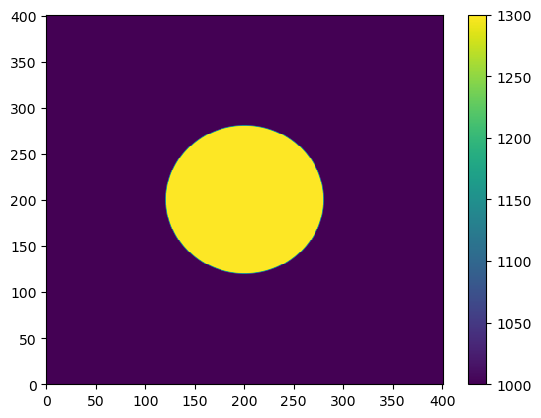

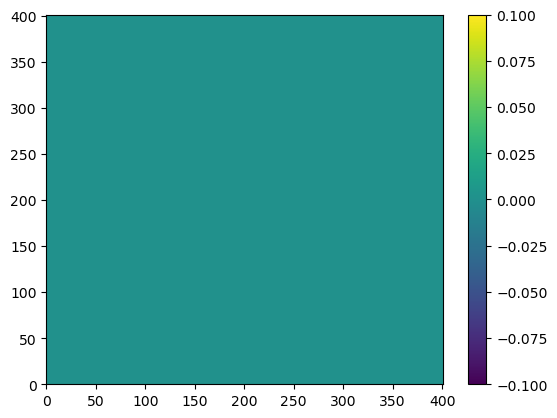

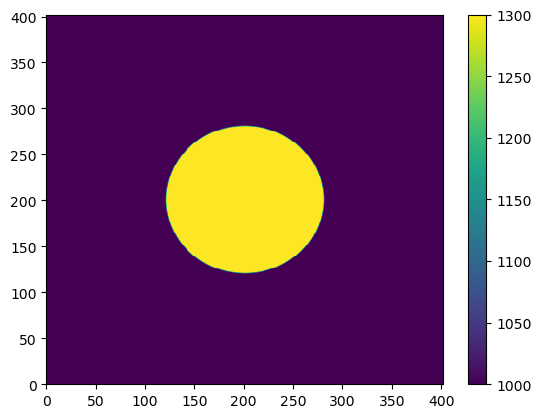

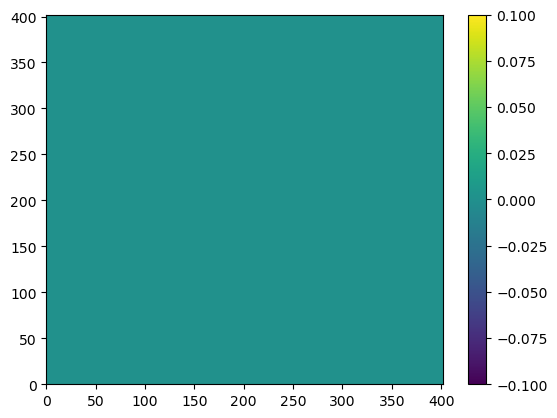

Creating Markers...
Initial condition...
  0.526225 seconds (14 allocations: 127.589 MiB, 18.58% gc time)
  0.435157 seconds (15 allocations: 127.589 MiB)
  0.519632 seconds (14 allocations: 127.614 MiB, 9.12% gc time)
  0.487102 seconds (15 allocations: 127.614 MiB)


┌ Warning: `vendor()` is deprecated, use `BLAS.get_config()` and inspect the output instead
│   caller = npyinitialize() at numpy.jl:67
└ @ PyCall /home/maxrudolph/.julia/packages/PyCall/L0fLP/src/numpy.jl:67


In [6]:
# NOTE - this code was for testing marker interpolation routine optimizations.
include("Markers.jl")
nx = 401
ny = nx
markx=10
marky=10
W = 5e5
H = 5e5

bc = BoundaryConditions(0,0,0,0) # currently does nothing but is required argument to stokes solver.

grid = CartesianGrid(W,H,nx,ny)
println("Creating Markers...")
markers = Markers(grid,["T","rho","eta"],["material"] ; nmx=markx,nmy=marky,random=false)
println("Initial condition...")
initial_conditions!(markers)

tmp1, = marker_to_basic_node( markers,grid,markers.scalars[1:1,:])
@time tmp1, = marker_to_basic_node( markers,grid,markers.scalars[1:1,:])
tmp2, = marker_to_basic_node( markers,grid,["T",])
@time tmp2, = marker_to_basic_node( markers,grid,["T",])

figure()
pcolormesh(tmp1)
colorbar()
show()

figure()
pcolormesh(tmp2-tmp1)
colorbar()
show()


tmp1, = marker_to_cell_center( markers,grid,markers.scalars[1:1,:])
@time tmp1, = marker_to_cell_center( markers,grid,markers.scalars[1:1,:])

tmp2, = marker_to_cell_center( markers,grid,["T",])
@time tmp2, = marker_to_cell_center( markers,grid,["T",])

figure()
pcolormesh(tmp1)
colorbar()
show()

figure()
pcolormesh(tmp2-tmp1)
colorbar()
show()

# Timing/Performance

The cell below runs a single timestep at a specified resolution. It was useful for figuring out why certain parts of the code were extremely slow. It was also extremely helpful to use Julia's Profile.jl package to profile specifiec subroutines.

In [8]:
function single_timestep(ny,nx)
    W = 5e5
    H = 5e5
    gx = 0.0
    gy = 10.0
    bc = BoundaryConditions(0,0,0,0) # currently does nothing but is required argument to stokes solver.
    markx = 5
    marky = 5
    seconds_in_year = 3.15e7
    plot_interval = 1e5*seconds_in_year # plot interval in seconds
    end_time = 3e7*seconds_in_year
    dtmax = plot_interval
    grid = CartesianGrid(W,H,nx,ny)
    println("Creating Markers...")
    markers = Markers(grid,["T","rho","eta"],["material"] ; nmx=markx,nmy=marky,random=false)
    println("Initial condition...")
    @time initial_conditions!(markers)

    # define arrays for k, rho, cp, H at the basic nodes. Fill them with constant values for now.
    kThermal = 3.0 .*ones(grid.ny,grid.nx);
    Cp = 1250. .* ones(grid.ny,grid.nx);
    H = zeros(grid.ny,grid.nx);

    time = 0.0
    iout=0
    # Get density and viscosity from the markers.
    println("Marker -> basic nodes")
    @time rho_new, eta_s_new = marker_to_basic_node(markers,grid,["rho","eta"]);
    
    if time > 0.0
        nanind = findall(isnan.(rho_new))
        rho_new[nanind] = rho[nanind]
        eta_s_new[nanind] = eta_s[nanind]     
    end
    
    global rho   = copy(rho_new)
    global eta_s = copy(eta_s_new)
    println("Viscosity basic nodes -> cell centers")
    @time eta_n = viscosity_to_cell_centers(grid,eta_s_new)

    # assemble and solve the stokes equations
    println("Form Stokes")
    @time L,R = form_stokes(grid,eta_s_new,eta_n,rho_new,bc,gx,gy)
    println("Solve Stokes")
    @time solution = L\R
    
    vx,vy,P = unpack(solution,grid;ghost=true)
    vxc,vyc = velocity_to_centers(grid,vx,vy)
    dt = compute_timestep(grid,vxc,vyc;dtmax=dtmax)
    
    # get temperature at cell centers
    println("Temperature to cell centers")

    @time Tlast, = marker_to_cell_center(markers,grid,["T",])
    if time > 0.0
        
    end
    Tlast = ghost_temperature(grid,Tlast);

    # assemble and solve the energy equation
    println("Assemble T")
    @time L,R = assemble_energy_equation_center(grid,rho,Cp,kThermal,H,Tlast,dt);
    println("Solve T")
    @time Tnew = L\R;
    Tnew = reshape(Tnew,grid.ny,grid.nx);
    println("Ghost temperature values")
    @time Tnew = ghost_temperature(grid,Tnew);
    
    dTemp = Tnew-Tlast
    println("Subgrid temp relaxation")
    @time dT_subgrid_node = subgrid_temperature_relaxation!(markers,grid,Tlast,Cp[1,1],kThermal[1,1],dt)
    dT_remaining = dTemp - dT_subgrid_node
    println("Cell center change to markers")
    @time cell_center_change_to_markers!(markers,grid,dT_remaining,"T")
    
    # if time == 0.0 || time - last_plot >= plot_interval
    #     last_plot = time 
    #     name = @sprintf("output_chapter11/viz.%04d.vtr",iout)
    #     eta_s = zeros(grid.ny,grid.nx)
    #     vn = velocity_to_basic_nodes(grid,vxc,vyc)

    #     visualization(grid,rho,eta_s,vn,P,Tnew,time/seconds_in_year;filename=name)
    #     name = @sprintf("output_chapter11/markers.%04d.vtp",iout)
    #     visualization(markers,time/seconds_in_year;filename=name)
    #     iout += 1
    # end
    println("Move markers")
    @time move_markers_rk2!(markers,grid,vxc,vyc,dt)
    return markers,grid,vxc,vyc,dt
    time += dt
end

@time markers,grid,vxc,vyc,dt = single_timestep(401,401)
@time move_markers_rk2!(markers,grid,vxc,vyc,dt)

Creating Markers...
Initial condition...
  0.101387 seconds
Marker -> basic nodes
  0.146454 seconds (19 allocations: 69.929 MiB)
Viscosity basic nodes -> cell centers
  0.003369 seconds (2 allocations: 1.227 MiB)
Form Stokes
  0.183560 seconds (34 allocations: 245.760 MiB)
Solve Stokes
 10.707484 seconds (71 allocations: 2.000 GiB, 0.20% gc time)
Temperature to cell centers
  0.164398 seconds (15 allocations: 35.603 MiB)
Assemble T
  0.032837 seconds (32 allocations: 47.762 MiB)
Solve T
  1.171412 seconds (73 allocations: 276.453 MiB)
Ghost temperature values
  0.000475 seconds (5 allocations: 2.460 MiB)
Subgrid temp relaxation
  0.569266 seconds (43 allocations: 127.004 MiB)
Cell center change to markers
  0.313203 seconds (10 allocations: 784 bytes)
Move markers
  0.682872 seconds (34 allocations: 244.449 MiB, 39.48% gc time)
 14.200417 seconds (1.12 k allocations: 3.262 GiB, 2.22% gc time)
  0.443221 seconds (30 allocations: 244.448 MiB)
